<a href="https://colab.research.google.com/github/Rakeshscode/Data-Science/blob/main/Unit2Project_RakeshRavi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install preliz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.6/505.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 17.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
osqp 0.6.7.post0 requires scipy!=1.12.0,>=0.13.2, but you have scipy 1.12.0 which is incompatible.


In [3]:
import preliz as pz


In [4]:
import numpy as np
import arviz as az
import pymc as pm

Roger Federer is a professional tennis player from Switzerland who held world No 1 for 310 weeks. He has the second most single titles of all time (103). Many consider 2006 to be his prime year where he ended with a 92-5 record. The shot to start any tennis match is the serve which is done through a toss and feet behind the baseline hitting into the box opposite from your body. You can either make, miss, or a let which means you redo the serve. I have played tennis for 8 years and learned throughout my years through private coaching that pros aim for a 65% 1st serve while on the tour or a 78 of 120 serves in a match. How good was Federer's first serve during his "prime" year?

<Axes: >

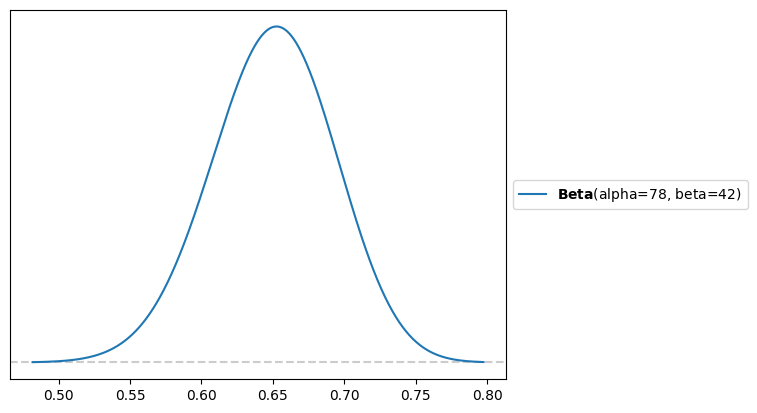

In [5]:
pz.Beta(alpha=78,beta=42).plot_pdf()


Now will make predictions with only prior knowledge.

In [8]:
#store the prior distribution for the Free Throw (FT) percentage
FS_prior = pz.Beta(alpha=78,beta=42)

#preliz does not have a function that returns the mode, so I will use a formula
FS_prior_mode = (FS_prior.alpha - 1)/(FS_prior.alpha + FS_prior.beta - 2)

#the mean mean first, then median, and finally mode
FS_prior.mean(), FS_prior.median(), FS_prior_mode

(0.65, 0.6508359341900957, 0.652542372881356)

These estimates of Federer's first serve percentage (about 65%, 65.08%, 65.25%) each minimize how "wrong" our guess will be, according to different things, called loss functions.

We observe Federer make 4697 out 7491 first serves in 2006 in all levels,surfaces, and rounds. Let's consider the chance, or likelihood, of this happening.

Made first serves are represented by $θ$, and misses by 1 - $θ$. Because first serves are independent, we can again represent a bunch of makes and misses through multiplication.

<Axes: >

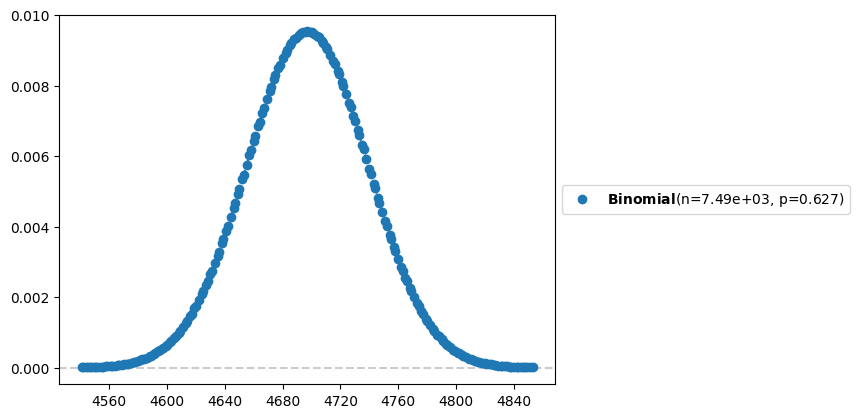

In [9]:
pz.Binomial(n=7491, p = 4697/7491).plot_pdf()

The probability of Roger Federer true first serve percentage in tennis given the first serves we've seen him serve thus far is:

$p(θ|y) ∝ p(y|θ)p(θ) = Beta(α_{new}=α+k,β_{new}=n-k+β)$

Now that we have a formula, let's use our computer to answer our question: How good was Federer's serve during his "prime" year?

In [11]:
#prior information
alpha_old = 78
beta_old = 42

#likelihood info, or data from the NBA
k = 4679 #makes
n = 7491 #total attempts

#'analytic' here means that we found the solution directly using a closed form
# mathematical formula
analytic_FS = pz.Beta(alpha = alpha_old + k,beta = beta_old + n - k )

#Federer' expected FS%. Mode and median are also acceptable, but note that I
#said 'expect', which techinally calls for the mean.
analytic_FS.mean()

0.6250164235974248

<Axes: >

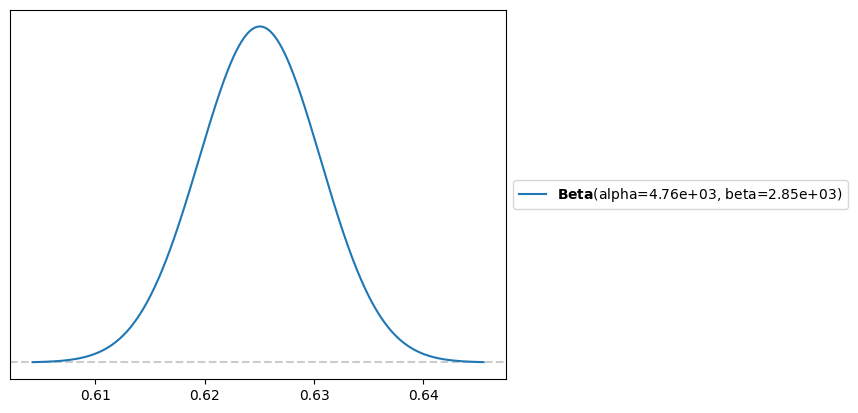

In [12]:
analytic_FS.plot_pdf()

A single number guess overstates how confident we are in guessing. The entire distribution represents all possible guesses we could make (given our assumptions), AND tells us how likely each guess is. The height of the curve represents how likely we are to see a particular θ.

For example, θ is Federer's true first serve percentage in the NBA, so the θ associated with the highest point on the curve is Federer's most likely FS%, or the mode. But other FS%s near the mode are also very likely, so anything near the mode is a more than reasonable guess. Unfortunately (fortunately?), "near the mode" is entirely up to us to determine--we'll elaborate more on that each unit.

The point is that the whole posterior distribution, the whole curve, gives all the information about our guess.

Now that we have some inuition and skills on how to guess Federer's FS%, a natural extension is to wonder if we can predict the results of his actual first throws.

In [14]:
#loading pymc, the fancy library of functions that allows us to only focus on θ
import pymc as pm

In [15]:
#the makes we've seen from 2006
FS_makes = np.repeat(1, 4679)

#the misses we've seen from the 2006
FS_misses = np.repeat(0, 2812)

#combine makes and misses into one array
FS_data = np.concatenate( [FS_makes,FS_misses] )

In [16]:
#Nearly every single model we will build in this class will have
#the below outline as its foundation. Get hyped.

with pm.Model() as fedr_FS_model:
  #we define our prior with the makes and misses from Euroleague
  #notice how we make alpha and beta floats by using '.'
  θ = pm.Beta('θ' , alpha = 78. , beta = 42.)

  #we define our likelihood, which is how we process the free throws
  #we've seen Federer make in 2006
  #Think of Bernoulli as a stand in for the binomial distribution
  #It doesn't have inherent info about number of attempts, but number of attempts
  #is included in the data anyway.
  y = pm.Bernoulli('y', p = θ, observed = FS_data)

  #this part is new. We sample from our posterior because we don't actually
  #have a formula for it.
  idata_FS = pm.sample(1000)

In [17]:
#arviz is a companion data visualization library for pymc
import arviz as az

<Axes: title={'center': 'θ'}>

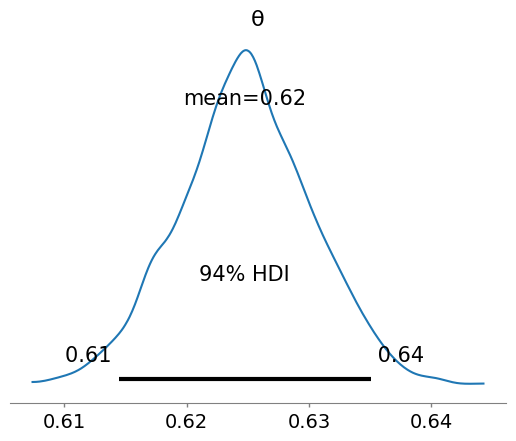

In [19]:
#vizualize the 1000 samples from the pymc model of the posterior
az.plot_posterior(idata_FS)

Let's compare this to the analytic solution.

<Axes: >

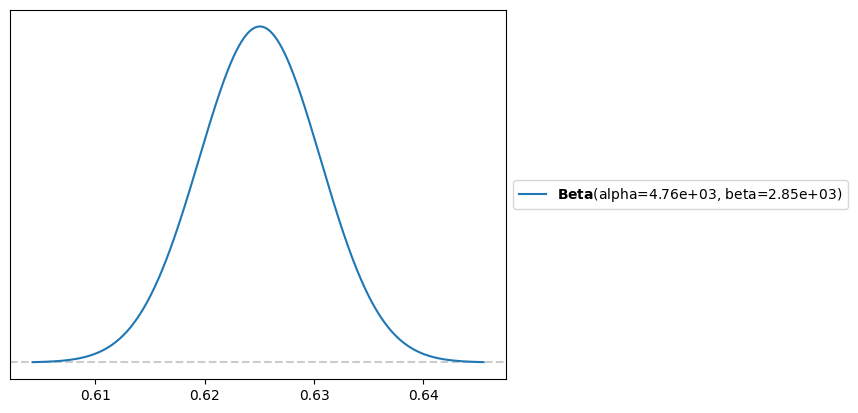

In [21]:
#probability density function (pdf) of the analytic solution
analytic_FS.plot_pdf()

<Axes: title={'center': 'θ'}>

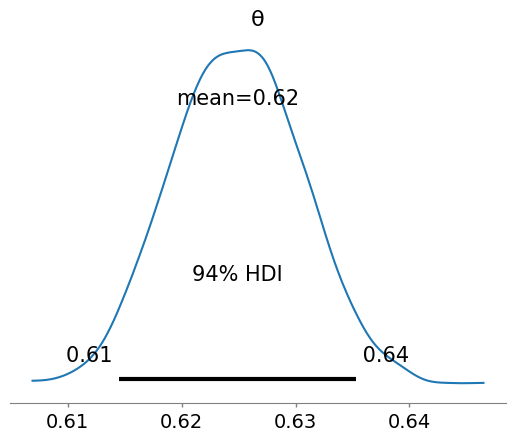

In [22]:
#vizualize 1000 samples from the analytic model.
#Recall that analytic_FT = pz.Beta(alpha = alpha_old + 7,beta = beta_old + n - k )
#This is beta dist. with the total number of makes and total misses as parameters
az.plot_posterior( {'θ' : analytic_FS.rvs(1000)} )

Now that we have some idea what our fancy pymc model gives us, let's use our it to make predictions.

In [24]:
#The below function needs to know two things in order to make predictions:
#-the samples from the posterior; these are stored in idata_FS
#-the model that generated those samples, which we called Fedr_FS_model
# The last input tells the function to store those predictions in idata_FS

pm.sample_posterior_predictive(idata_FS, model=fedr_FS_model, extend_inferencedata=True)

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [25]:
#stack the two MCMC chains together for a total of 2000 samples, or predictions
#Why 2000? 1000 per chain. Why 1000? Because we asked for 1000 samples when
#we specified the model.
stacked_FS = az.extract(idata_FS, group="posterior_predictive")

In [26]:
stacked_FS.sel(sample=0).sel(draw=0).y.to_series().values

array([1, 0, 1, ..., 0, 1, 1])

The above array is a prediction for the next block of 7491 free throws. If a 1 is first, that means we predict Federer will make the next FS, with a 0 corresponding to a miss. This guess is based only on his first serves in 2006, and my prior knowledge of professinal players.

What is Roger Federer's true First Serve percentage (FS%) in 2006?

The posterior mean of 0.62 refelcts a balance between our prior expectation of .65 and the observed data that suggests a lower mean of .627. It indicates that, given the data and our prior beliefs, the most probable first serve percentage is now considered to be 62%. The shift towards 62% suggests that the sheer amount of observed data had a weightful impact on the given result. I am surprised by the result because I would have predicted Federer's prime year yielded a much higher first serve percentage than what your average pro is expected to serve, closer to 70%. Federer is also my favorite player of all time and the "GOAT" in my mind so that heavily influenced my reaction to the posterior mean.